In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
import sys
sys.path.append('../')
from Misc import visualize, condorcet, save_load_files
from GPPrefAct import pref_model_predict

# Load Trained Model Data

In [2]:
occ_num = 10
num_data = 40

In [3]:
syn_occ_data_config_file = '../data/config_files/syn/diff_utilities_config/syn_occupants.json'

with open(syn_occ_data_config_file, 'r') as fd:
    syn_occ_data_config = json.loads(fd.read())

In [4]:
a = syn_occ_data_config['O' + str(occ_num)]['a']
b = syn_occ_data_config['O' + str(occ_num)]['b']

In [5]:
print a
print b

3
2


In [6]:
# Load actions data
actions_data = np.loadtxt('../data/syn_data/syn_occ/actions_data/train/' +
                         'O_a' + str(a) + '_b' + str(b) + '_' + str(num_data) + '_.csv', delimiter = ',')


In [7]:
actions_data

array([[ 0.34693878,  0.75510204],
       [ 0.16326531,  0.87755102],
       [ 0.24489796,  0.48979592],
       [ 0.26530612,  0.16326531],
       [ 0.95918367,  0.18367347],
       [ 0.2244898 ,  0.85714286],
       [ 0.10204082,  0.16326531],
       [ 0.30612245,  0.6122449 ],
       [ 0.        ,  0.14285714],
       [ 0.32653061,  0.06122449],
       [ 0.02040816,  0.12244898],
       [ 0.24489796,  0.42857143],
       [ 1.        ,  0.14285714],
       [ 0.91836735,  0.06122449],
       [ 0.08163265,  0.12244898],
       [ 0.48979592,  0.51020408],
       [ 1.        ,  0.40816327],
       [ 0.87755102,  0.75510204],
       [ 0.24489796,  0.36734694],
       [ 0.53061224,  0.40816327],
       [ 0.2244898 ,  0.32653061],
       [ 0.85714286,  0.91836735],
       [ 0.83673469,  0.57142857],
       [ 0.36734694,  0.59183673],
       [ 0.30612245,  0.28571429],
       [ 0.        ,  0.08163265],
       [ 0.08163265,  0.46938776],
       [ 0.51020408,  0.46938776],
       [ 0.95918367,

In [8]:
X_current = actions_data[:,1]
X_previous = actions_data[:,0]

In [9]:
gpflow_model_object_file = '../data/syn_data/tmp_data/model_objects/' + 'O_a' + str(a) + '_b' + str(b) + '_' + str(num_data) + '_.pkl'
gpflow_samples_file = '../data/syn_data/tmp_data/samples/' + 'O_a' + str(a) + '_b' + str(b) + '_' + str(num_data) + '_.txt'

In [10]:
m = save_load_files.read_pickle_object(gpflow_model_object_file)
samples = np.loadtxt(gpflow_samples_file, delimiter=',' )

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

# Condorcet

In [11]:
min_grid = 0.
max_grid = 1.
num_grid = 10

In [12]:
ComfDis = condorcet.syn_comfort_discomfort(predict=pref_model_predict.predict,
                                           m = m, samples = samples,
                                           grid_min = min_grid, grid_max = max_grid, 
                                           num_grid = num_grid)

In [13]:
p_satisfied, p_brighter, p_darker = ComfDis.cope_comfort_brighter_darker()

In [14]:
np.savez('../data/syn_data/tmp_data/condorcet_results/' + 'O_a' + str(a) + '_b' + str(b) + '_' + str(num_data) + '_.npz',
         p_satisfied = p_satisfied, p_brighter = p_brighter, p_darker = p_darker,
         min_grid = min_grid, max_grid = max_grid, num_grid = num_grid)

In [15]:
def comfort_discomfort_probabilities(satisfied, brighter, darker, X, Tn):
    """
    Thompson sampling plot
    Inputs:
    X (size: L) : grid points
    p_mean_mat (size: L x N) : Matrix containing copeland scores corresponding to grid_points
    L : grid points points used for calculating copeland score
    N : MCMC samples
    Tn : number of thompson copeland score samples to display
    Output:
    Copeland Score Thompson sampling plots 
    (see Preferential Bayesian Optimization paper - Figure 3)
    """
    
    plt.figure(figsize=(12,10))
    # sampling from indexes
    indexes = np.arange(satisfied.shape[0])

    # index sample
    ind_samp = np.random.choice(indexes, size = Tn , replace = False)
    
    s = satisfied[ind_samp,:]
    b = brighter[ind_samp, :]
    d = darker[ind_samp, :]
    
    plt.figure(figsize=(12,10))
    line, = plt.plot(X, np.mean(s, 0), lw=2, color = 'g')
    plt.fill_between(X, np.percentile(s, 5, axis=0), np.percentile(s, 95, axis=0),
                     color=line.get_color(), alpha = 0.2)
    
    line, = plt.plot(X, np.mean(d, 0), lw=2, color = 'r')
    plt.fill_between(X, np.percentile(d, 5, axis=0), np.percentile(d, 95, axis=0),
                     color=line.get_color(), alpha = 0.2)
    
    line, = plt.plot(X, np.mean(b, 0), lw=2, color = 'b')
    plt.fill_between(X, np.percentile(b, 5, axis=0), np.percentile(b, 95, axis=0),
                     color=line.get_color(), alpha = 0.2)

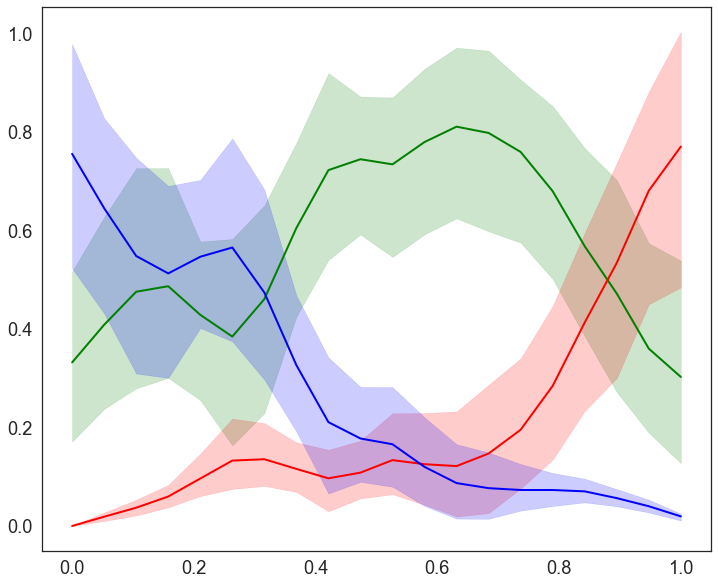

In [16]:
comfort_discomfort_probabilities(p_satisfied, p_brighter, p_darker, ComfDis.Xt, 1000)

In [18]:
p_satisfied.shape

(5000, 20)

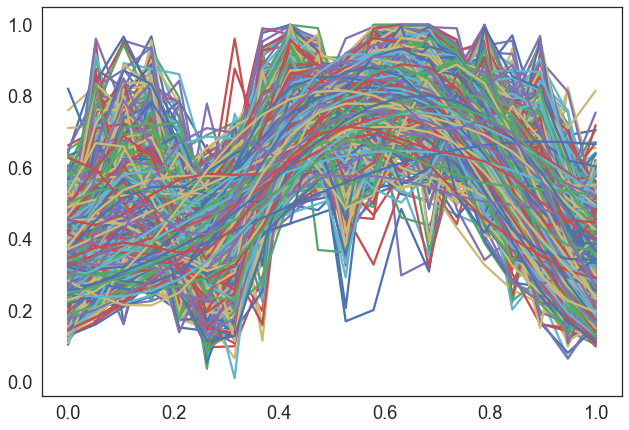

In [23]:
for i in xrange(1000):
    plt.plot(ComfDis.Xt, p_satisfied[i,:])